![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

*Se importan las librerias necesarias para correr el notebook*

In [2]:
# Importación de librerías
%matplotlib inline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import pandas as pd
import numpy as np

*Se importan los datos*

In [3]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


*Se realiza la separación de variables predictoras y variable de interés. Además, se separan los datos en set de* **entrenamiento** *y* **prueba** 

In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [6]:
#Celda 1
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold  
        self.left = left  
        self.right = right  
        self.value = value 

class DT_Regressor:
    def __init__(self,max_depth=None):
        self.max_depth = max_depth
  
    # Se crea una función para calcular el MSE
    def calcular_MSE(self, y):
        return np.mean((y - np.mean(y))**2)

    # Se crea una función para encontrar el mejor split
    def best_split(self, X, y):
        # Se inicializan los parámetros del mejor MSE, mejor threshold y mejor feature
        mejor_MSE = float('inf')
        mejor_threshold = None
        mejor_feature = None

        # Para cada feuture se encuentra el split que genere el menor valor de MSE. Al cual se le denomina best_split 
        for feature in X.columns:
            val_unicos_feature = X[feature].unique()
            for threshold in val_unicos_feature:
                left_index = X[feature] <= threshold
                right_index = ~left_index

                mse_l = self.calcular_MSE(y[left_index])
                mse_r = self.calcular_MSE(y[right_index])

                MSE = mse_l + mse_r

                if MSE < mejor_MSE:
                    mejor_MSE = MSE
                    mejor_threshold = threshold
                    mejor_feature = feature
                    
        return mejor_feature, mejor_threshold

    # Se crea una función para realizar el crecimiento recursivo del árbol
    def tree_grow(self, X, y, depth):
        
        # Se crea un nodo hoja cuando se alcanza algún parámetro de parada (como el max_depth)
        if depth == self.max_depth or np.unique(y).size == 1:
            return Node(value=np.mean(y))

        feature, threshold = self.best_split(X, y)
        left_index = X[feature] <= threshold
        right_index = ~left_index

        X_l = self.tree_grow(X[left_index], y[left_index], depth + 1)
        X_r = self.tree_grow(X[right_index], y[right_index], depth + 1)

        return Node(feature=feature, threshold=threshold, left=X_l, right=X_r)

    # Se realiza una función para ajustar los datos al árbol de decisión creado
    def fit_tree(self, X, y):
        X = pd.DataFrame(X)
        y = pd.Series(y)
        self.root = self.tree_grow(X, y, 0)

    # Se realiza una función para predecir cada nodo
    def predict_node(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            # Nos enfocamos en lado izquierdo
            return self.predict_node(x, node.left)
        else:
            # Nos enfocamos en lado derecho
            return self.predict_node(x, node.right)

    # Se realiza la predicción de los valores para cada nodo
    def predict(self, X):
        X = pd.DataFrame(X)
        return np.array([self.predict_node(x, self.root) for _, x in X.iterrows()])

In [7]:
tree_regressor = DT_Regressor(max_depth=10)
tree_regressor.fit_tree(X_train,y_train)

In [8]:
y_test_pred = tree_regressor.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)
print("El modelo de Arbol de Decisión muestra un RMSE de {} y un MAE de {} en el set de Test".format(rmse, mae))

El modelo de Arbol de Decisión muestra un RMSE de 2617.17796178115 y un MAE de 2004.6642496638112 en el set de Test


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [9]:
# Celda 2
from sklearn.tree import DecisionTreeRegressor

train, test = train_test_split(data, test_size=0.33, random_state=42)
X_tr = train.iloc[:, 1:]
X_tst = test.iloc[:, 1:]
y_tr = train.Price
y_tst = test.Price

# Se crea un arreglo de 1 a 20
np.random.seed(1)
nums = np.arange(1, 21)

# Creación de 10 muestras de bootstrap 
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train_b = train.iloc[sample, 1:]
    y_train_b = train.iloc[sample, 0]
    treereg.fit(X_train_b, y_train_b)
    y_pred.iloc[:,i] = treereg.predict(X_tst)
# Predicciones promedio para cada observación del set de test
y_pred = y_pred.mean(axis=1)
rmse = sqrt(mean_squared_error(y_tst, y_pred))
mae = mean_absolute_error(y_tst, y_pred)
print("El modelo de Bagging manual muestra un RMSE de {} y un MAE de {} en el set de Test".format(rmse, mae))

El modelo de Bagging manual muestra un RMSE de 1796.4355868399332 y un MAE de 1340.0160739030025 en el set de Test


En el caso de Bagging manual con 10 arboles de regresión podemos observar un desempeño superior al del arbol de decisión individual. En este caso el RMSE es de 1796.43 contra el RMSE de 2617.17 del arbol de decisión individual, y asimismo el MAE es de 1340.02, siendo inferior al del arbol de decisión individual (2004.66). Con esto podemos concluir que el modelo de Bagging manual con 10 arboles de decisión tiene un poder predictivo superior al arbol individual, lo que probablemente se deba a la sensibilidad de los árboles de decisión individuales frente al muestreo al momento de realizar la partición. Es claro que al utilizar varios árboles se puede aumentar la flexibilidad del modelo y compensar los errores de arboles individuales.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [10]:
# Celda 3
from sklearn.ensemble import BaggingRegressor
n_features = X_train.shape[1]
max_features=max(1,int(np.log10(n_features)))
clf = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=1, n_jobs=-1, max_features=max_features)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print("El modelo de Bagging muestra un RMSE de {} y un MAE de {} en el set de Test".format(rmse, mae))

El modelo de Bagging muestra un RMSE de 3201.894621872612 y un MAE de 2500.809053915107 en el set de Test


In [11]:
n_features = X_train.shape[1]
max_features=max(1,int(np.log(n_features)))
clf = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=1, n_jobs=-1, max_features=max_features)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print("El modelo de Bagging muestra un RMSE de {} y un MAE de {} en el set de Test".format(rmse, mae))

El modelo de Bagging muestra un RMSE de 2671.0127988157697 y un MAE de 2074.976088225145 en el set de Test


Se entreno un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)`como el log en base 10. Teniendo en cuenta que el Log en base 10 con las nueve (9) variables que se consideran tendría un valor de 0.95, se aproxima este valor a 1. Así, se estaría entrenando cada estimador base con un `max_features` de 1, es decir, se estaría entrenando con 1 sola variable predictora (diferente para cada árbol). Lo anterior, disminuye el poder predictivo para cada árbol y por ende, el del ensamblaje.

Ahora bien, si se decide realizar un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` como el logaritmo natural implicaria entrenar cada estimador base con 2 variables predictoras (diferentes para cada árbol). Lo anterior, mejoraria el poder predictivo para cada árbol y por ende, el del ensamblaje. 

Cabe resaltar que, el número de variables independientemente del método de logaritmo que se desee aplicar es bajo. Así, se debería calibrar el parámetro *max_features* para tener un modelo que nos permita tener un mayor poder predictivo.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [12]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
rmse_rfi = sqrt(mean_squared_error(y_test, y_pred))
mae_rfi = mean_absolute_error(y_test, y_pred)
print("El modelo de Random Forest muestra un RMSE de {} y un MAE de {} en el set de Test".format(rmse_rfi, mae_rfi))

El modelo de Random Forest muestra un RMSE de 1755.8727670097485 y un MAE de 1307.0800496834686 en el set de Test


Se entrena un modelo de Randon Forest para regresión. Al comparar el modelo realizado en el apartado 2 de Bagging manual con el modelo de Random Forest, podemos observar que el último presenta un desempeño superior pues tiene un RMSE de 1755.87 que es menor al modelo de Bagging manual. Con esto podemos concluir que el modelo de Random Forest tiene un poder predictivo muy superior al Bagging manual. 

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

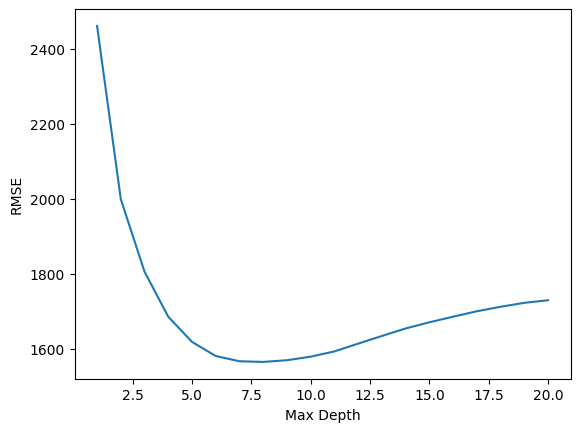

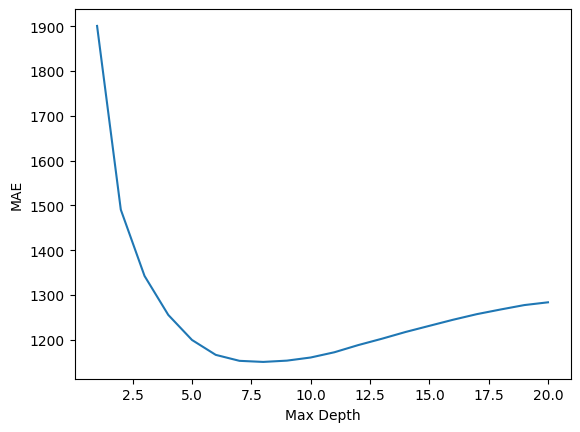

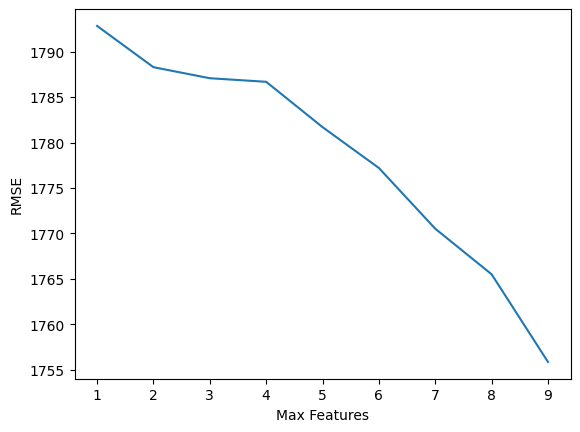

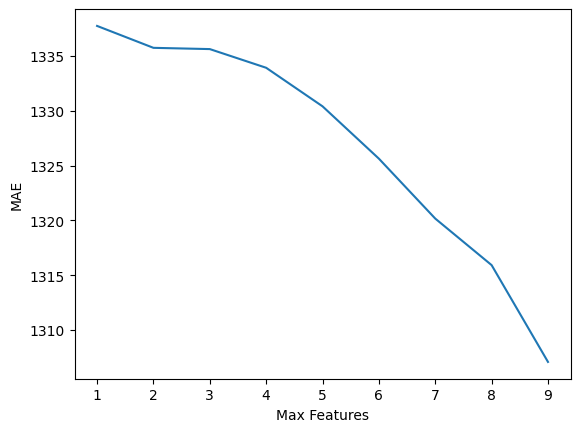

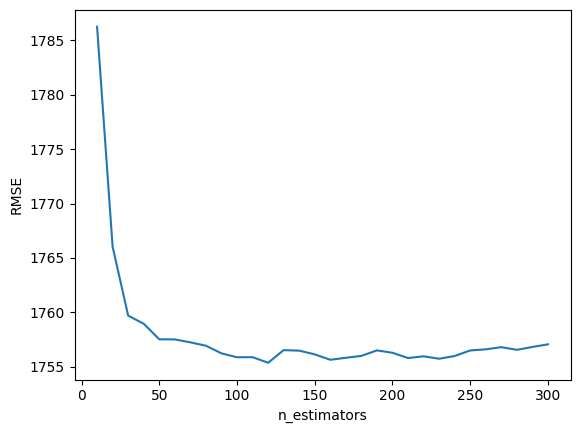

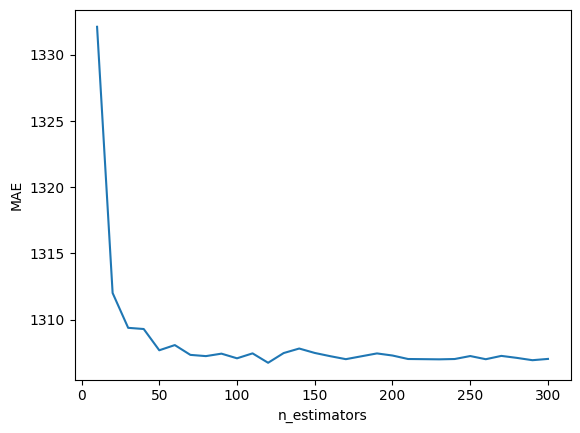

El mejor modelo de Random Forest muestra un RMSE de 1565.7925906185949 y un MAE de 1151.1990155228773 en el set de Test


In [13]:
# Celda 5
import matplotlib.pyplot as plt

#Max Depth
max_depths = range(1, 21, 1)
rmse_scores = []
mae_scores = []
for depth in max_depths:
    clf = RandomForestRegressor(max_depth=depth, random_state=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    rmse_scores.append(sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
plt.plot(max_depths, rmse_scores)
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.show()
plt.plot(max_depths, mae_scores)
plt.xlabel('Max Depth')
plt.ylabel('MAE')
plt.show()

#Max Features
max_features = range(1, 10, 1)
rmse_scores = []
mae_scores = []
for mf in max_features:
    clf = RandomForestRegressor(max_features=mf, random_state=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    rmse_scores.append(sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
plt.plot(max_features, rmse_scores)
plt.xlabel('Max Features')
plt.ylabel('RMSE')
plt.show()
plt.plot(max_features, mae_scores)
plt.xlabel('Max Features')
plt.ylabel('MAE')
plt.show()

#N Estimators
n_estimators = range(10, 310, 10)
rmse_scores = []
mae_scores = []
for estimator in n_estimators:
    clf = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    rmse_scores.append(sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
plt.plot(n_estimators, rmse_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.show()
plt.plot(n_estimators, mae_scores)
plt.xlabel('n_estimators')
plt.ylabel('MAE')
plt.show()

# Mejor Modelo
clf = RandomForestRegressor(max_depth=8, max_features=9, n_estimators=50, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
rmse_rf = sqrt(mean_squared_error(y_test, y_pred))
mae_rf = mean_absolute_error(y_test, y_pred)
print("El mejor modelo de Random Forest muestra un RMSE de {} y un MAE de {} en el set de Test".format(rmse_rf, mae_rf))

Se calibraon los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión.

* El parámetro de **max_depth** se calibró con valores entre 1 y 20 encontrando que el valor que hace que el RMSE y el MAE sea menor es el *max_depht* de 8.

* El parámetro de **max_features** se calibró con valores entre 1 y 9 encontrando que el número de variables que hace que el RMSE y el MAE sea menor es el *max_features* de 9. 

* El parámetro de **n_estimators** se calibró con valores entre 1 y 300. Se decidio que el valor para el mejor modelo es 50 ya que al aumentar el *n_estimators* no hay cambios significativos en el RMSE y el MAE pero computacionalmente puede ser más costoso.  


Al comparar el desempeño del modelo Random Forest con el modelo calibrado de Random Forest, podemos evidenciar que el último presenta valores de RMSE y MAE inferiores al modelo sin calibrar. Lo anterior, nos indica que tiene valor calibrar los parpametros del modelo.


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [14]:
# Celda 6
from xgboost import XGBRegressor
clf = XGBRegressor(random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
rmse_xgi = sqrt(mean_squared_error(y_test, y_pred))
mae_xgi = mean_absolute_error(y_test, y_pred)
print("El modelo de XGBoost muestra un RMSE de {} y un MAE de {} en el set de Test".format(rmse_xgi, mae_xgi))

El modelo de XGBoost muestra un RMSE de 1621.4197004256812 y un MAE de 1186.634392366123 en el set de Test


**Comparación XGBoost Vs. Random Forest calibrado**

En este caso el RMSE es de 1621.41 del XGBoost contra el RMSE de 1565.79 del Random Forest calibrado, y asimismo el MAE es de 1186.63, siendo superior al del Random Forest calibrado (1151.19). Con esto podemos concluir que el modelo de Random Forest calibrado tiene un poder predictivo superior al XGBoost.

**Comparación XGBoost Vs. Random Forest sin calibrar**

En este caso el RMSE es de 1621.41 del XGBoost contra el RMSE de 1755.87 del Random Forest sin calibrar, y asimismo el MAE es de 1186.63, siendo inferior al del Random Forest sin calibrar (1307.08). Con esto podemos concluir que el modelo de Random Forest sin calibrar tiene un poder predictivo inferior al XGBoost.

Lo anterior, demuestra la importancia de la calibración de parámetros de los modelos. 

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

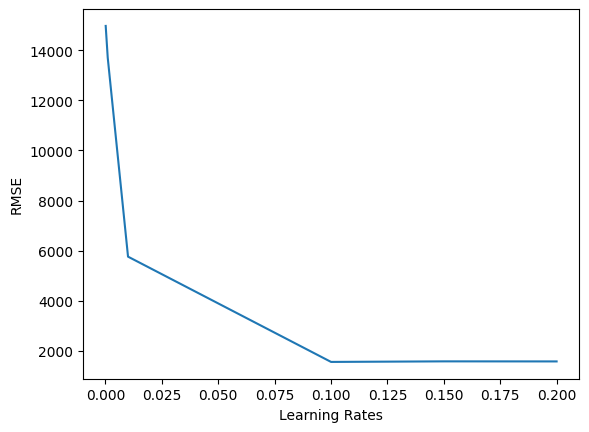

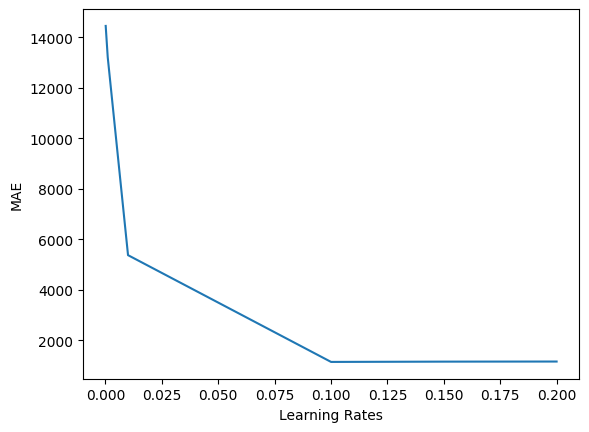

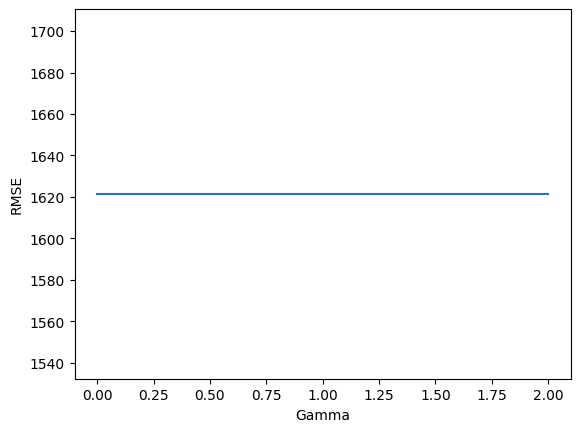

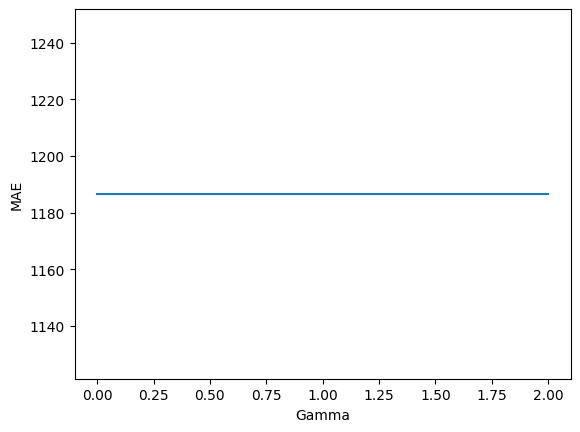

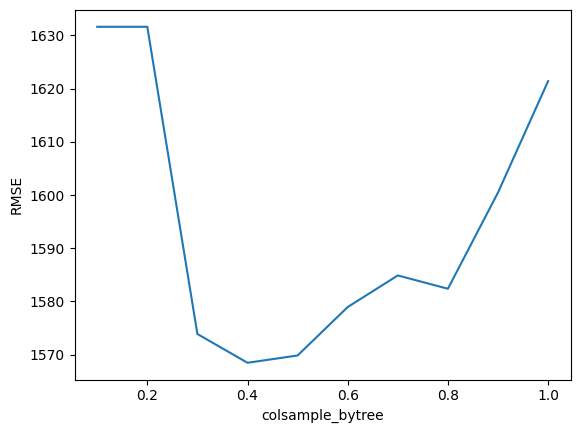

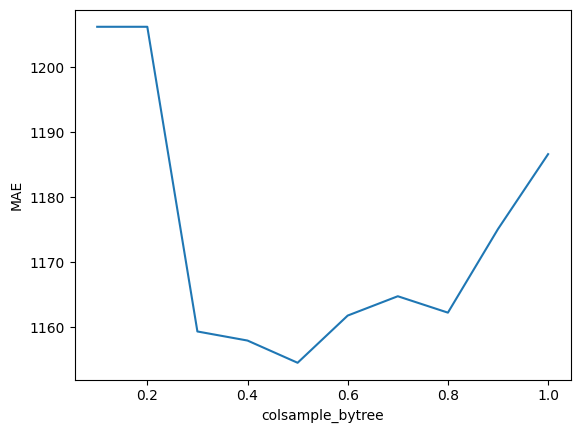

El mejor modelo de XGBoost muestra un RMSE de 1556.163541694859 y un MAE de 1145.149529789667 en el set de Test


In [15]:
# Celda 7
#Learning Rate
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.15, 0.2]
rmse_scores = []
mae_scores = []
for lr in learning_rates:
    clf = XGBRegressor(learning_rate=lr, random_state=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    rmse_scores.append(sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
plt.plot(learning_rates, rmse_scores)
plt.xlabel('Learning Rates')
plt.ylabel('RMSE')
plt.show()
plt.plot(learning_rates, mae_scores)
plt.xlabel('Learning Rates')
plt.ylabel('MAE')
plt.show()

#Gamma
gammas = [0.0001, 0.001, 0.01, 0.1, 1, 2]
rmse_scores = []
mae_scores = []
for g in gammas:
    clf = XGBRegressor(gamma=g, random_state=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    rmse_scores.append(sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
plt.plot(gammas, rmse_scores)
plt.xlabel('Gamma')
plt.ylabel('RMSE')
plt.show()
plt.plot(gammas, mae_scores)
plt.xlabel('Gamma')
plt.ylabel('MAE')
plt.show()

#Colsample by Tree
colsample_bytrees = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
rmse_scores = []
mae_scores = []
for cst in colsample_bytrees:
    clf = XGBRegressor(colsample_bytree=cst, random_state=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    rmse_scores.append(sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
plt.plot(colsample_bytrees, rmse_scores)
plt.xlabel('colsample_bytree')
plt.ylabel('RMSE')
plt.show()
plt.plot(colsample_bytrees, mae_scores)
plt.xlabel('colsample_bytree')
plt.ylabel('MAE')
plt.show()

#Mejor Modelo
clf = XGBRegressor(learning_rate=0.1, colsample_bytree=0.4, random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
rmse_xg = sqrt(mean_squared_error(y_test, y_pred))
mae_xg = mean_absolute_error(y_test, y_pred)
print("El mejor modelo de XGBoost muestra un RMSE de {} y un MAE de {} en el set de Test".format(rmse_xg, mae_xg))

Se calibraron los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión.

* El parámetro de **learning rate** se calibró con valores entre 0.0001 y 0.2 encontrando que el valor que hace que el RMSE y el MAE sea menor es el *learning rate* de 0.1.

* El parámetro de **gamma** se calibró con valores entre 0.0001 y 2 encontrando que el valor de *gamma* no impacta el desempeño del modelo en este caso. 

* El parámetro de **colsample_bytree** se calibró con valores entre 0.1 y 1 encontrando que el valor que hace que el RMSE y el MAE sea menor es el *colsample_bytree* de 0.4 y 0.5, respectivamente. Se decidio elegir el *colsample_bytree* de 0.4 pues tendría un impacto computacional menor.


Al comparar el desempeño del modelo XGBoost con el modelo calibrado de XGBoost, podemos evidenciar que el último presenta valores de RMSE y MAE inferiores al modelo sin calibrar. Lo anterior, nos indica que tiene valor calibrar los parámetros del modelo.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

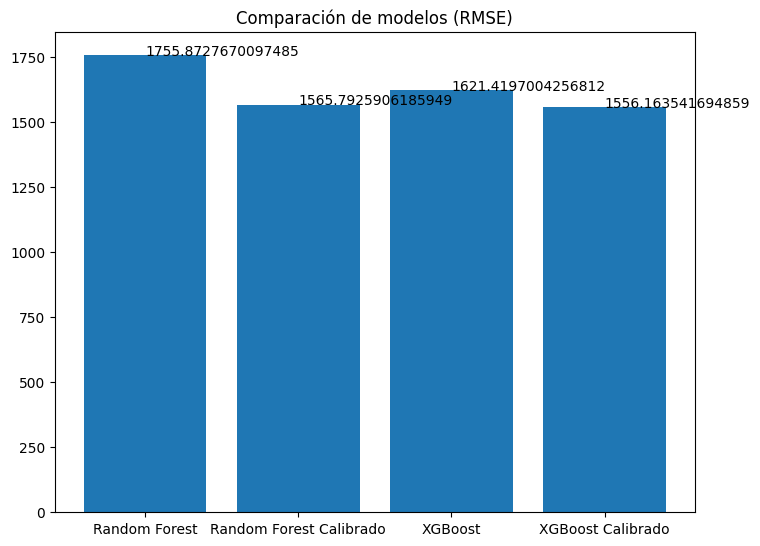

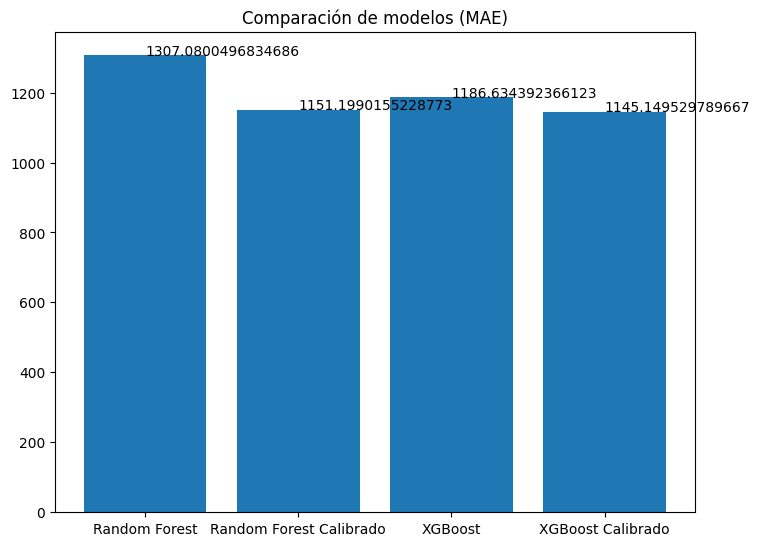

In [16]:
# Celda 8
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos (RMSE)")
ejeX = ['Random Forest', 'Random Forest Calibrado','XGBoost', 'XGBoost Calibrado']
ejeY = [rmse_rfi, rmse_rf, rmse_xgi, rmse_xg]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos (MAE)")
ejeX = ['Random Forest', 'Random Forest Calibrado','XGBoost', 'XGBoost Calibrado']
ejeY = [mae_rfi, mae_rf, mae_xgi, mae_xg]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()

Se realiza una gráfica de barras para comparar los resultados obtenidos de los diferentes modelos (random forest y XGBoost). Podemos evidenciar la importancia de la calibración de parámetros pues los modelos calibrados tienen mayor poder predictivo que los modelos sin calibrar. El mejor modelo sería el XGBoost calibrado pues presenta valores de RMSE y MAE menores al resto de modelos. 

Ahora bien, el mejor modelo XGBoost además de estar calibrado utiliza la técnica de boosting para mejorar la precisión del modelo. El boosting es una técnica que combina varios modelos más débiles para formar un modelo más fuerte y preciso. Teniendo en cuenta que la calibración de parámetros es importante para la predicción, tiene sentido que el modelo con el menor desempeño fue el Random Forest sin calibrar.

